# Chapter 01: Getting Started

This notebook explores the vangja time-series forecasting package using the classic Air Passengers dataset (similar to Facebook Prophet examples).

## Setup and Imports


In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from vangja import LinearTrend, FourierSeasonality
from vangja.utils import metrics

# Set random seed for reproducibility
np.random.seed(42)

print("Imports successful!")

Imports successful!


## 1. Load Air Passengers Dataset

The Air Passengers dataset is a classic time series dataset containing monthly totals of international airline passengers from 1949 to 1960.


In [3]:
# Download Air Passengers dataset
url = (
    "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
)
air_passengers = pd.read_csv(url)
air_passengers

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


The downloaded Air Passengers dataframe has columns "Month" and "Passengers". vangja components expect:
- `ds`: datetime column
- `y`: target values

Rename the columns and convert `ds` to datetime before further processing, e.g.:

In [4]:
# Rename columns to match vangja format
air_passengers.columns = ["ds", "y"]
air_passengers["ds"] = pd.to_datetime(air_passengers["ds"])

print(f"Dataset shape: {air_passengers.shape}")
print(f"Date range: {air_passengers['ds'].min()} to {air_passengers['ds'].max()}")
air_passengers.head()

Dataset shape: (144, 2)
Date range: 1949-01-01 00:00:00 to 1960-12-01 00:00:00


,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


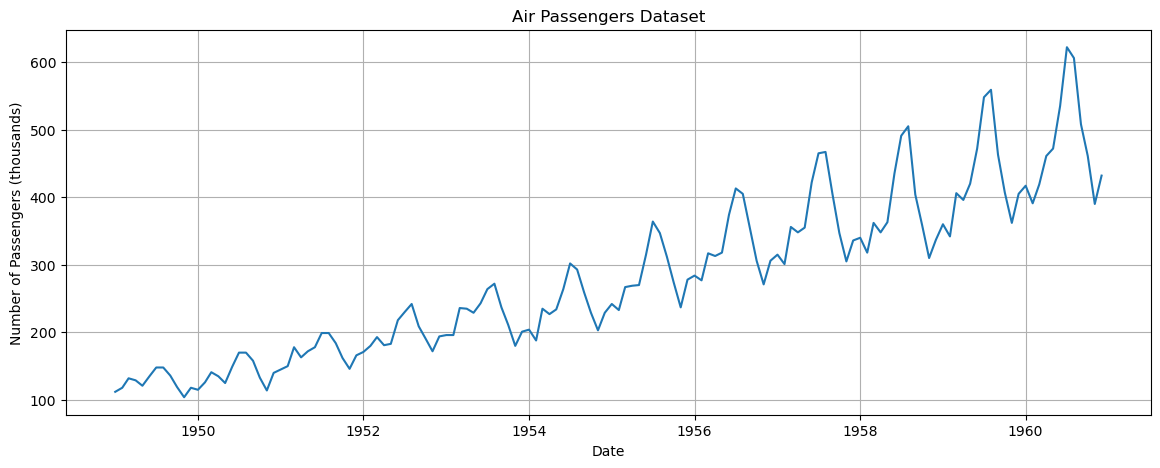

In [5]:
# Visualize the data
plt.figure(figsize=(14, 5))
plt.plot(air_passengers["ds"], air_passengers["y"])
plt.title("Air Passengers Dataset")
plt.xlabel("Date")
plt.ylabel("Number of Passengers (thousands)")
plt.grid(True)
plt.show()

## 2. Train/Test Split


In [6]:
# Split data: use last 12 months for testing
train = air_passengers[:-12].copy()
test = air_passengers[-12:].copy()

print(
    f"Training set: {train['ds'].min()} to {train['ds'].max()} ({len(train)} samples)"
)
print(f"Test set: {test['ds'].min()} to {test['ds'].max()} ({len(test)} samples)")

Training set: 1949-01-01 00:00:00 to 1959-12-01 00:00:00 (132 samples)
Test set: 1960-01-01 00:00:00 to 1960-12-01 00:00:00 (12 samples)


## 3. Model Air Passengers like Facebook Prophet

Facebook Prophet models time series as:

- Trend component (piecewise linear or logistic growth)
- Seasonality component (Fourier series)
- Holiday effects (optional)

For the Air Passengers dataset, we have:

- A clear upward trend
- Strong yearly seasonality
- Multiplicative seasonality (amplitude increases with level)


### 3.1 Additive Model


In [7]:
# Define an additive model: Trend + Yearly Seasonality + Weekly Seasonality
model_additive = (
    LinearTrend()
    + FourierSeasonality(period=365.25, series_order=10)
    + FourierSeasonality(period=7, series_order=3)
)

print(f"Model: {model_additive}")

Model: LT(n=25,r=0.8,tm=None) + FS(p=365.25,n=10,tm=None) + FS(p=7,n=3,tm=None)


In [8]:
# Fit the additive model
model_additive.fit(train)
print("Additive model fitted!")

Output()

Additive model fitted!


In [9]:
# Predict
future_additive = model_additive.predict(horizon=365, freq="D")
print(f"Predictions shape: {future_additive.shape}")
future_additive.head()

Predictions shape: (4352, 6)


,ds,t,lt_0_0,fs_0_0,fs_1_0,yhat_0
0,1949-01-01,0.000000,108.462884,-0.044380,0.002170,84.867545
1,1949-01-02,0.000251,108.532605,-0.051900,-0.002614,78.058796
2,1949-01-03,0.000502,108.602326,-0.058430,-0.006427,72.347272
3,1949-01-04,0.000753,108.672047,-0.063777,-0.000094,72.968074
4,1949-01-05,0.001004,108.741768,-0.067789,0.000725,71.252909


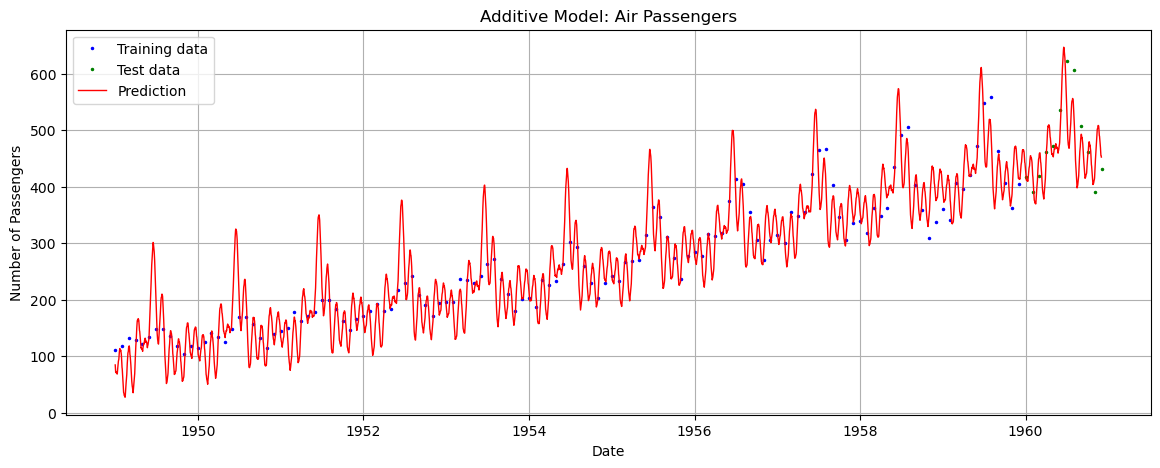

In [10]:
# Plot results
plt.figure(figsize=(14, 5))
plt.plot(train["ds"], train["y"], "b.", label="Training data", markersize=3)
plt.plot(test["ds"], test["y"], "g.", label="Test data", markersize=3)
plt.plot(
    future_additive["ds"],
    future_additive["yhat_0"],
    "r-",
    label="Prediction",
    linewidth=1,
)
plt.title("Additive Model: Air Passengers")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.legend()
plt.grid(True)
plt.show()

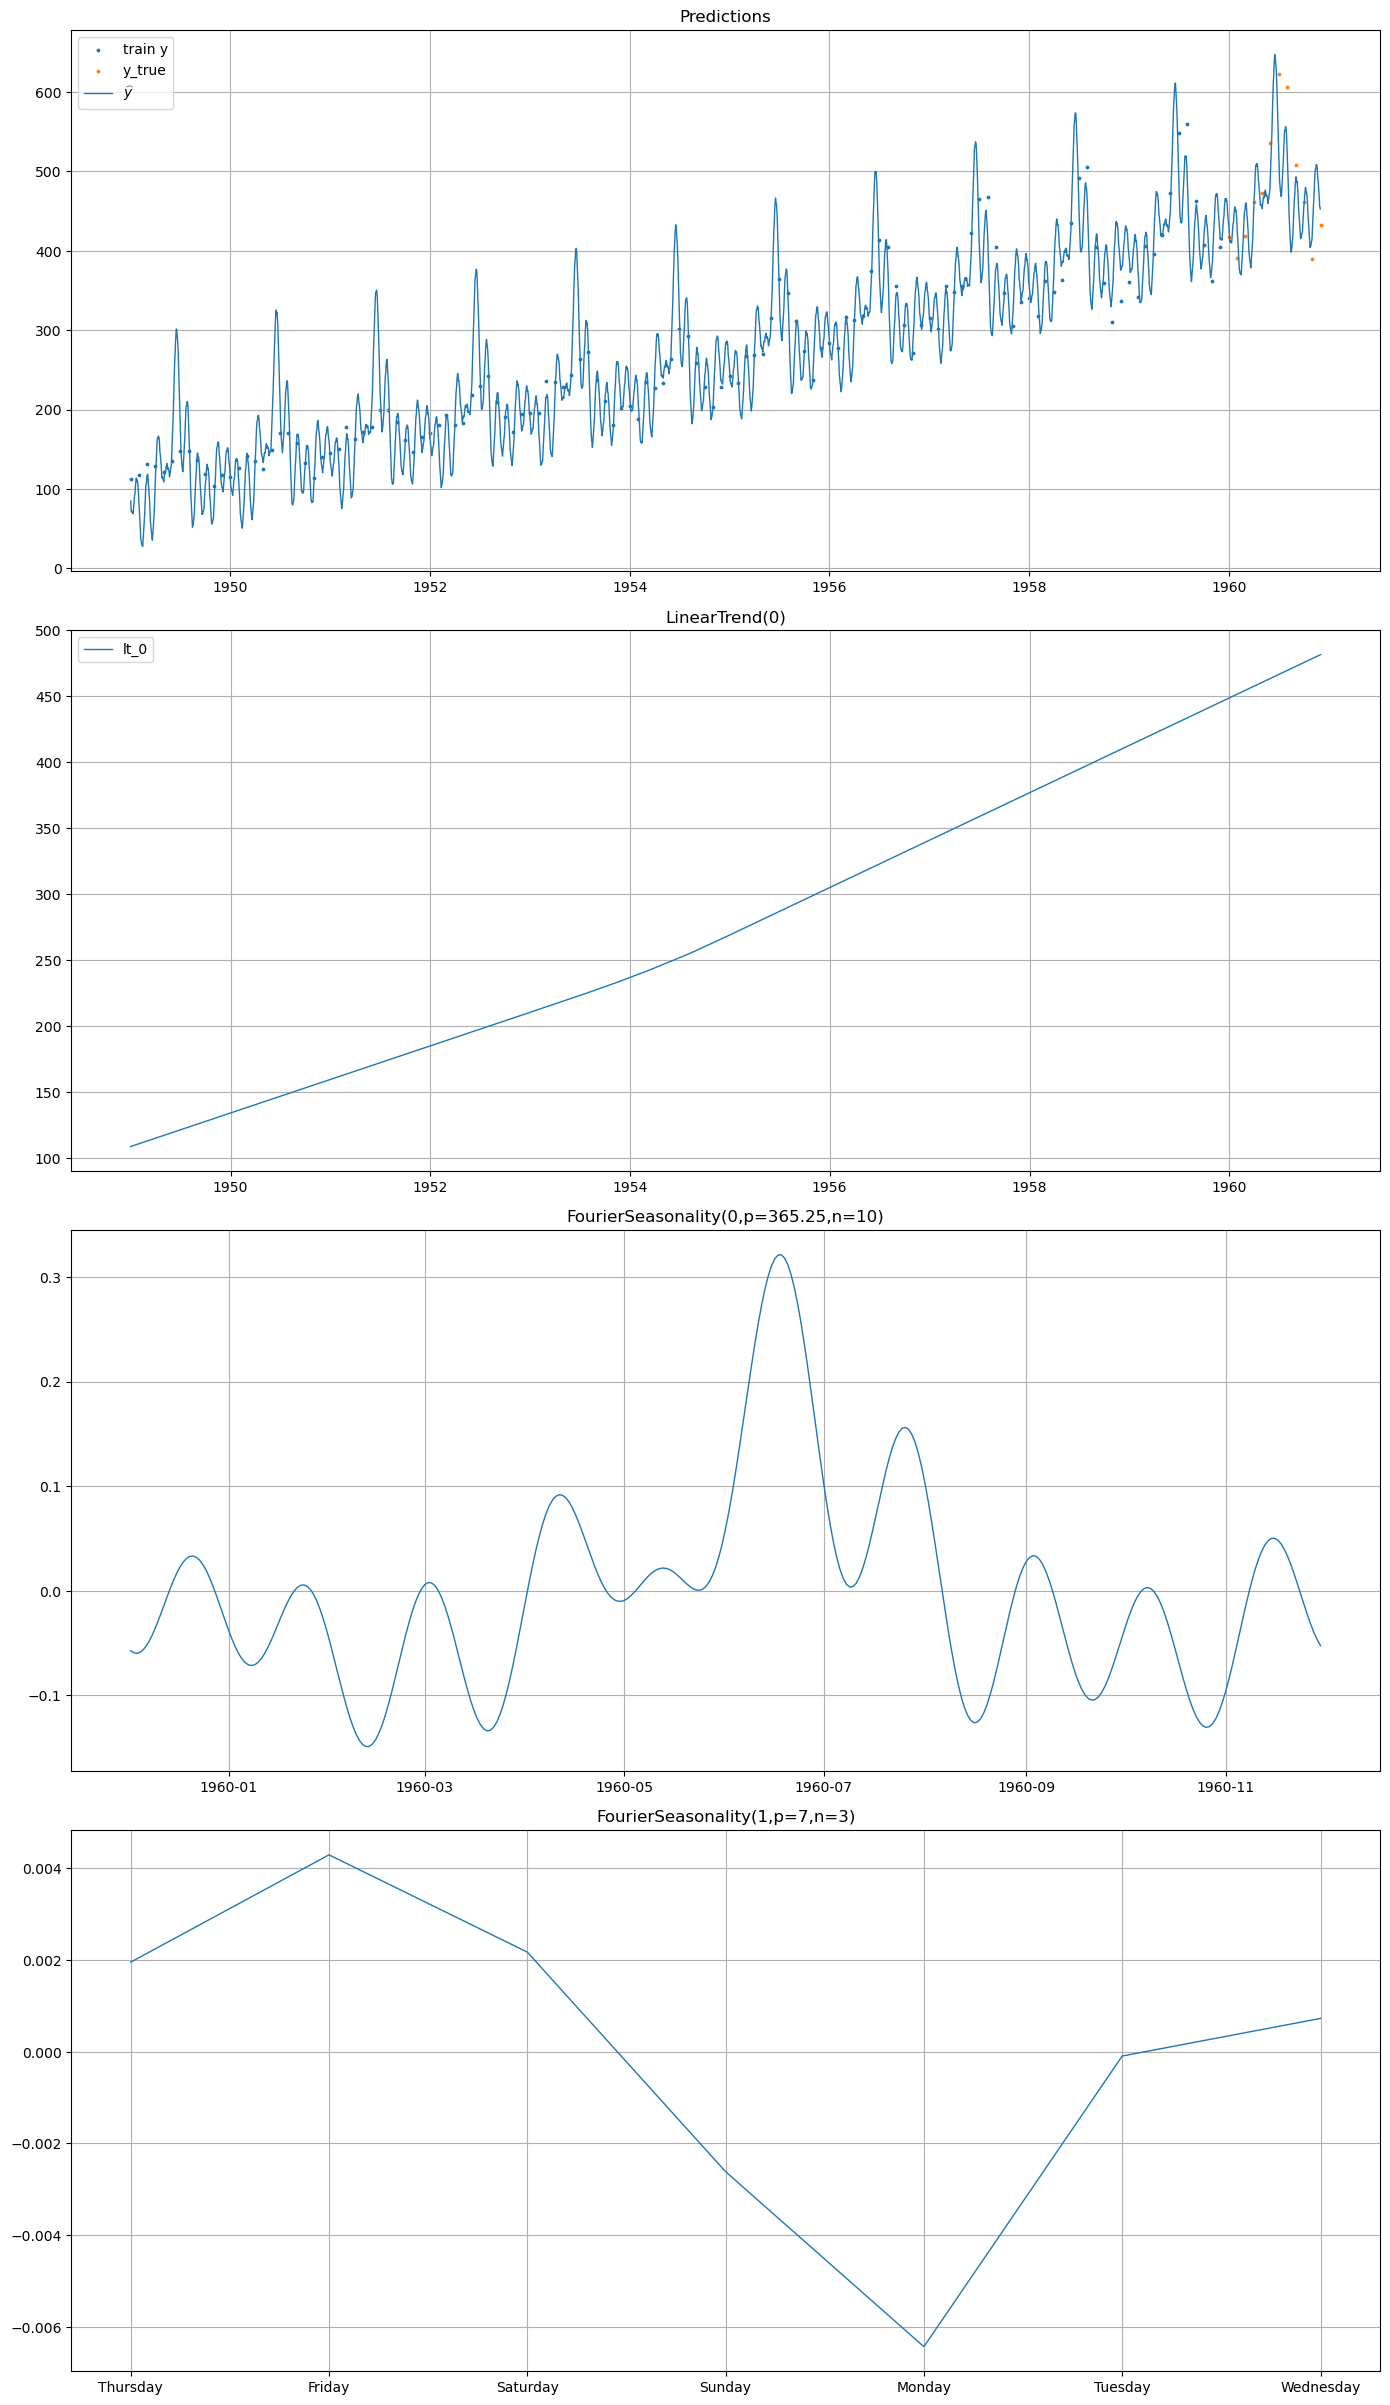

In [11]:
model_additive.plot(future_additive, y_true=test)
plt.tight_layout()
plt.show()

### 3.2 Multiplicative Model

The Air Passengers data shows multiplicative seasonality (variance increases with the trend). Let's try a multiplicative model: `y = trend * (1 + seasonality)`


In [12]:
# Define a multiplicative model
model_mult = LinearTrend(n_changepoints=25) ** (
    FourierSeasonality(period=365.25, series_order=10)
    + FourierSeasonality(period=7, series_order=3)
)

print(f"Model: {model_mult}")

Model: LT(n=25,r=0.8,tm=None) * (1 + FS(p=365.25,n=10,tm=None) + FS(p=7,n=3,tm=None))


In [13]:
# Fit the multiplicative model
model_mult.fit(train)
print("Multiplicative model fitted!")

Output()

Multiplicative model fitted!


We plot the results to show how the multiplicative seasonality better captures the increase of variance with the trend.

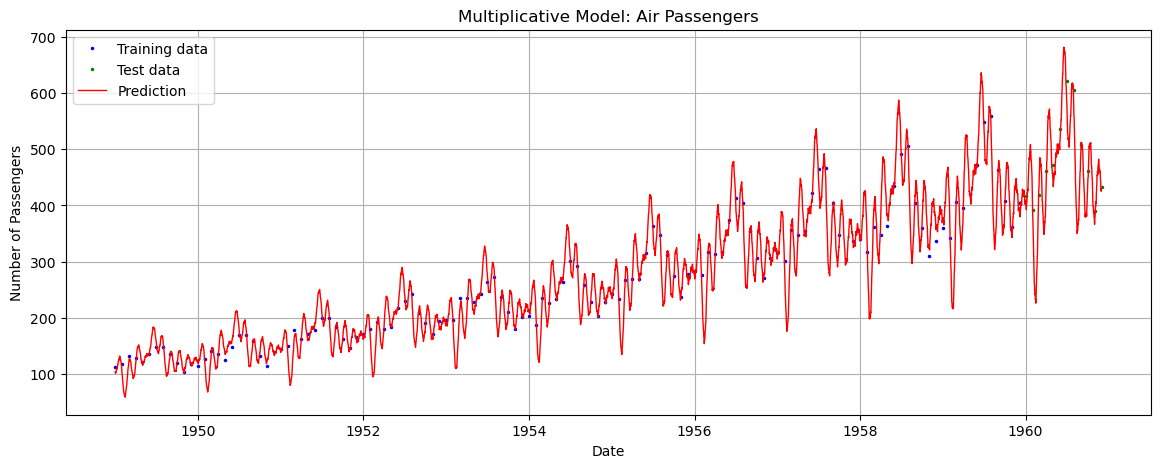

In [14]:
# Predict
future_mult = model_mult.predict(horizon=365, freq="D")

# Plot results
plt.figure(figsize=(14, 5))
plt.plot(train["ds"], train["y"], "b.", label="Training data", markersize=3)
plt.plot(test["ds"], test["y"], "g.", label="Test data", markersize=3)
plt.plot(
    future_mult["ds"], future_mult["yhat_0"], "r-", label="Prediction", linewidth=1
)
plt.title("Multiplicative Model: Air Passengers")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.legend()
plt.grid(True)
plt.show()

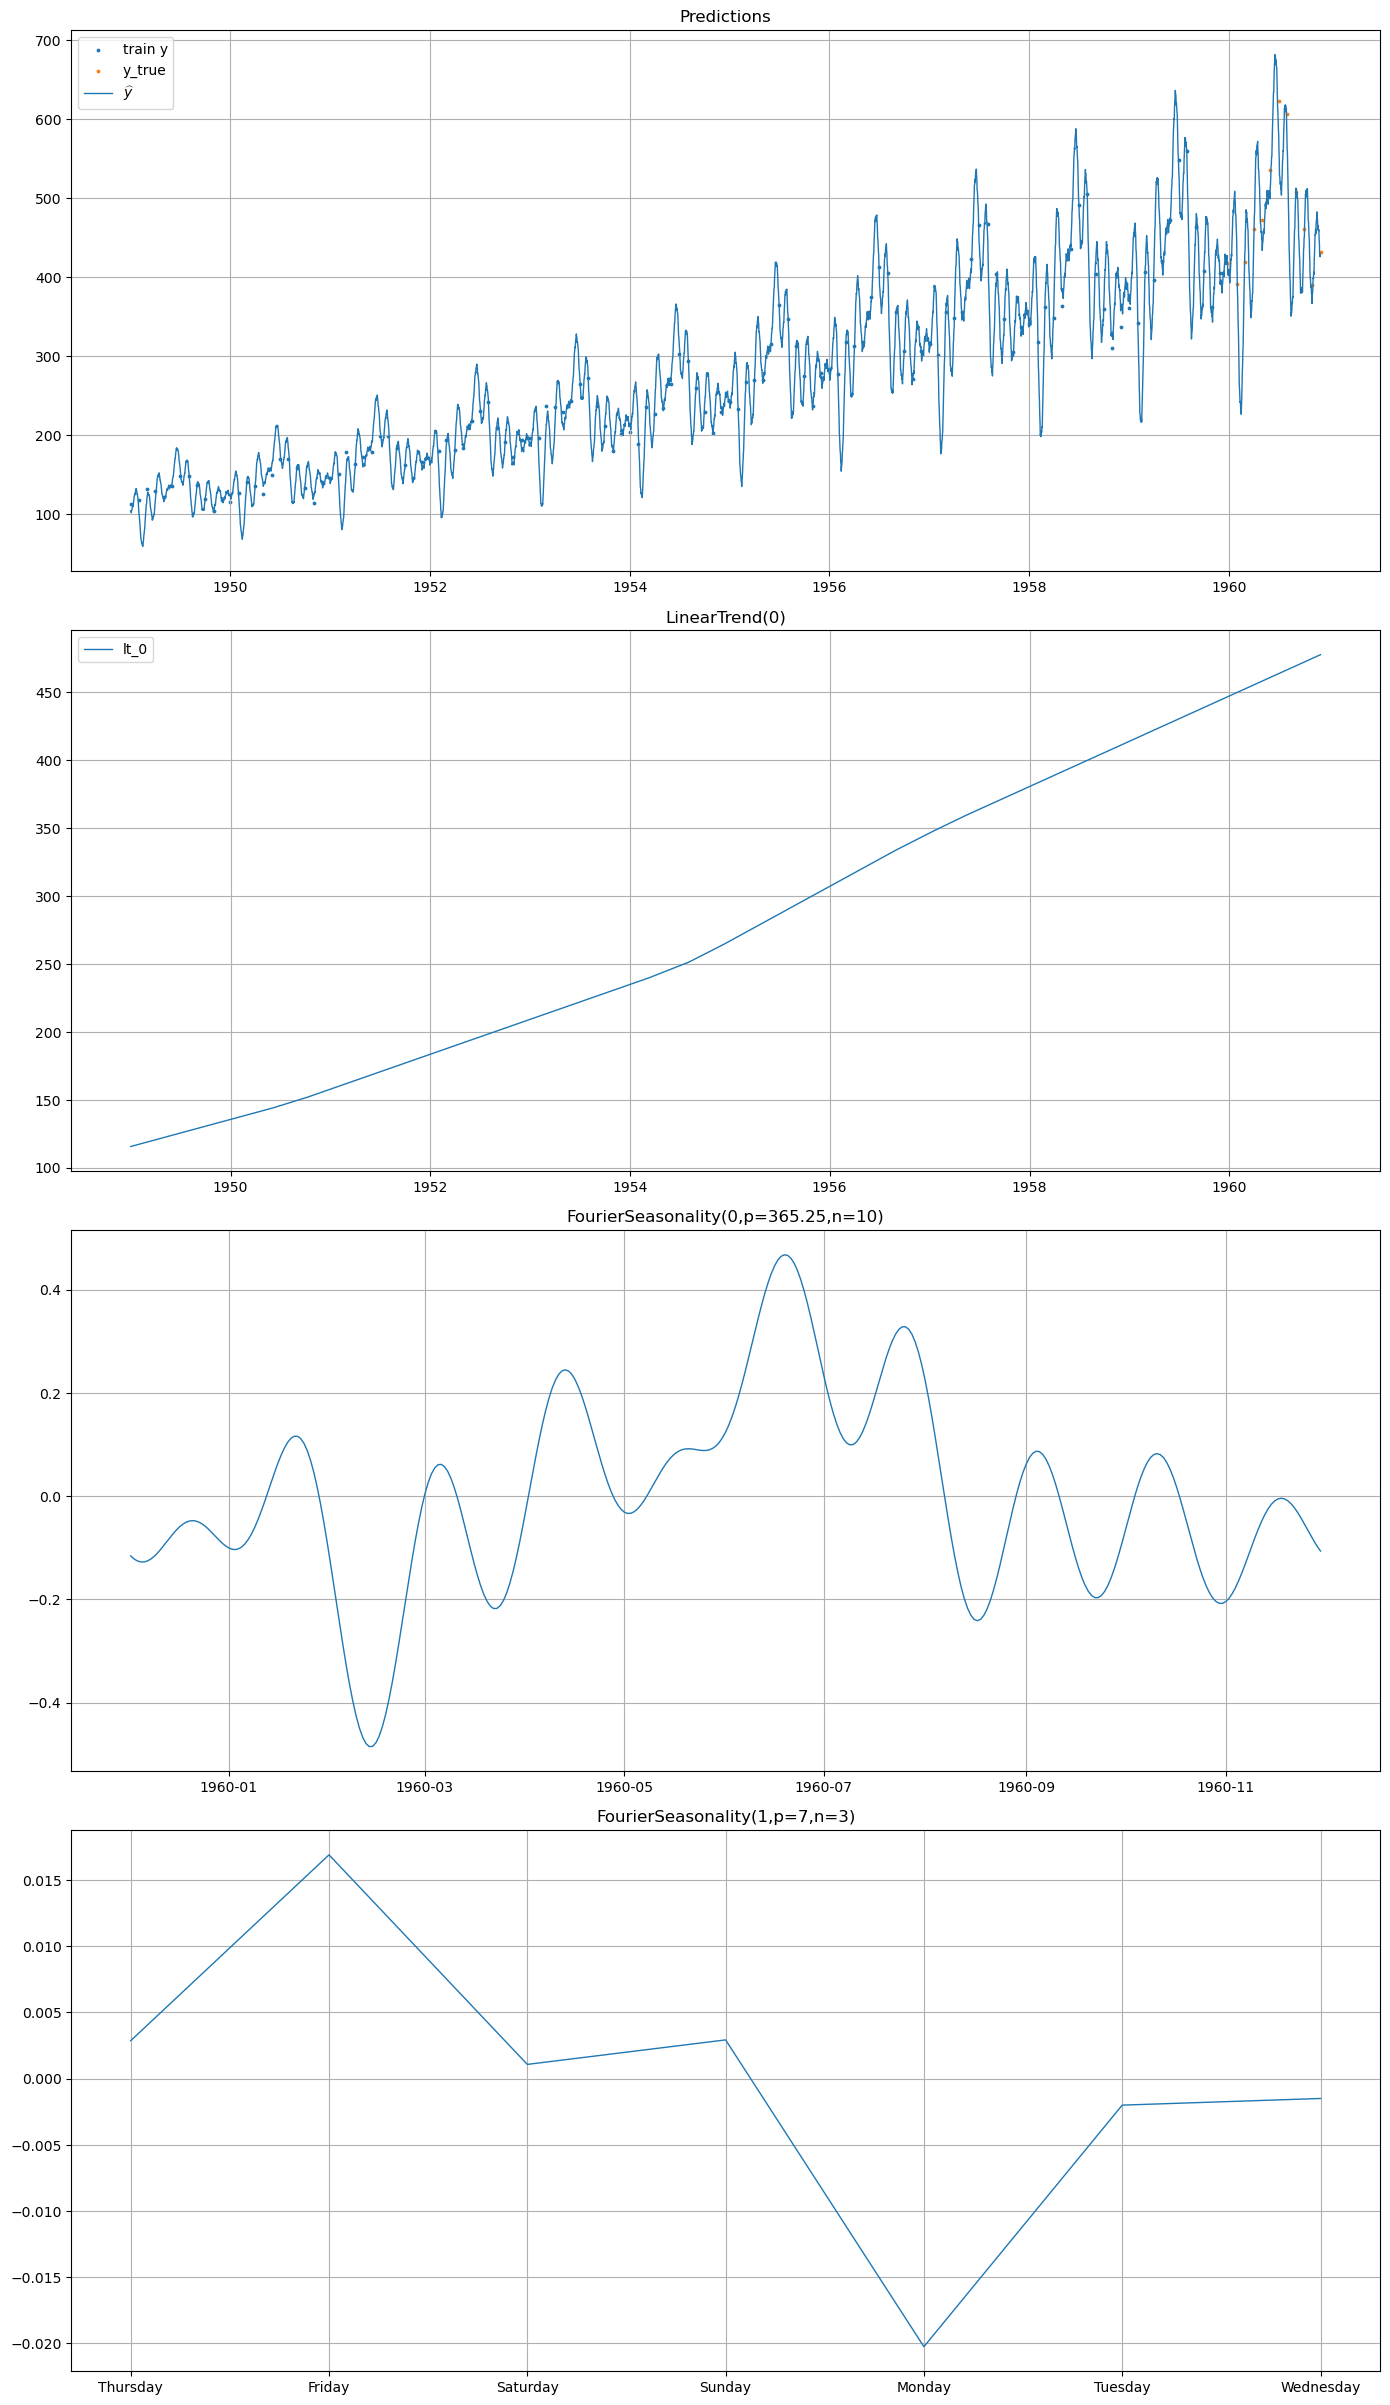

In [15]:
model_mult.plot(future_mult, y_true=test)
plt.tight_layout()
plt.show()

### Metrics comparison

We compare the standard metrics between the additive and the multiplicative models.

In [16]:
metrics_additive = metrics(test, future_additive, "complete")
print("Additive Model Metrics:")
display(metrics_additive)

Additive Model Metrics:


,mse,rmse,mae,mape
series,1988.497349,44.592571,34.349423,0.067574


In [17]:
metrics_mult = metrics(test, future_mult, "complete")
print("Multiplicative Model Metrics:")
display(metrics_mult)

Multiplicative Model Metrics:


,mse,rmse,mae,mape
series,629.010786,25.080087,21.254398,0.04267
